In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import networkx as nx
import numpy as np
from scipy import integrate
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from itertools import product
from sklearn.metrics.cluster import normalized_mutual_info_score



In [2]:
def sim_fromdist(dist):
    return 1/(1+dist)

def threshold_otsu_impl(matrix, nbins=0.001):
    
    all_colors = matrix.flatten()
    total_weight = len(all_colors)
    least_variance = -1
    least_variance_threshold = -1
    
    # create an array of all possible threshold values which we want to loop through
    color_thresholds = np.arange(np.min(matrix)+nbins, np.max(matrix)-nbins, nbins)
    
    # loop through the thresholds to find the one with the least within class variance
    for color_threshold in color_thresholds:
        bg_pixels = all_colors[all_colors < color_threshold]
        weight_bg = len(bg_pixels) / total_weight
        variance_bg = np.var(bg_pixels)

        fg_pixels = all_colors[all_colors >= color_threshold]
        weight_fg = len(fg_pixels) / total_weight
        variance_fg = np.var(fg_pixels)

        within_class_variance = weight_fg*variance_fg + weight_bg*variance_bg
        if least_variance == -1 or least_variance > within_class_variance:
            least_variance = within_class_variance
            least_variance_threshold = color_threshold
            
    return least_variance_threshold
# network backboning

def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in G.successors(u))
                for v in G.successors(u):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = G.successors(u)[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in G.predecessors(u))
                for v in G.predecessors(u):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''    
    
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alpha_in =  w['alpha_in']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alpha_in = 1
            try:
                alpha_out =  w['alpha_out']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alpha_out = 1  
            
            if cut_mode == 'or':
                if alpha_in<alpha_t or alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alpha_in<alpha_t and alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                


# Word semantics

In [3]:
simmatrix_languages = pd.read_csv("../data/multilingual_similarity_average.csv", index_col=0)
simmatrix_languages

,lang1,lang2
average_similarity,,
0.682879,no,vi
0.684863,no,zh
0.755766,no,nl
0.682239,no,ms
0.670596,no,tr
...,...,...
0.640285,bg,tl
0.719829,bg,cs
0.650152,uk,tl


In [4]:
country_to_language = {
    'RU': 'ru',  # Russia - Russian
    'VN': 'vi',  # Vietnam - Vietnamese
    'GB': 'en',  # United Kingdom - English
    'DE': 'de',  # Germany - German
    'RO': 'ro',  # Romania - Romanian
    'DK': 'da',  # Denmark - Danish
    'NZ': 'en',  # New Zealand - English
    'CA': 'en',  # Canada - English (could also be 'fr')
    'NL': 'nl',  # Netherlands - Dutch
    'IE': 'en',  # Ireland - English (Irish: 'ga' also official)
    'FI': 'fi',  # Finland - Finnish (Swedish: 'sv' also official)
    'SE': 'sv',  # Sweden - Swedish
    'CZ': 'cs',  # Czech Republic - Czech
    'FR': 'fr',  # France - French
    'HU': 'hu',  # Hungary - Hungarian
    'IT': 'it',  # Italy - Italian
    'US': 'en',  # United States - English
    'PL': 'pl',  # Poland - Polish
    'TR': 'tr',  # Turkey - Turkish
    'AE': 'ar',  # United Arab Emirates - Arabic
    'IN': 'hi',  # India - Hindi (many others; 'en' also widespread)
    'BG': 'bg',  # Bulgaria - Bulgarian
    'KR': 'ko',  # South Korea - Korean
    'NO': 'no',  # Norway - Norwegian
    'HR': 'hr',  # Croatia - Croatian
    'PH': 'tl',  # Philippines - Tagalog (Filipino)
    'MY': 'ms',  # Malaysia - Malay
    'SK': 'sk',  # Slovakia - Slovak
    'AU': 'en',  # Australia - English
    'TH': 'th',  # Thailand - Thai
    'ID': 'id',  # Indonesia - Indonesian
    'BR': 'pt',  # Brazil - Portuguese
    'RS': 'sr',  # Serbia - Serbian
    'SA': 'ar',  # Saudi Arabia - Arabic
    'HK': 'zh',  # Hong Kong - Chinese (Cantonese, Mandarin; 'zh' covers both)
    'ES': 'es',  # Spain - Spanish
    'MX': 'es',  # Mexico - Spanish
    'JP': 'ja',  # Japan - Japanese
    'UA': 'uk',  # Ukraine - Ukrainian
    'SG': 'en',  # Singapore - English (with Malay, Mandarin, Tamil)
    'BE': 'nl',  # Belgium - Dutch (also 'fr', 'de')
    'TW': 'zh',  # Taiwan - Chinese (Mandarin)
    'AR': 'es',  # Argentina - Spanish
    'PT': 'pt',  # Portugal - Portuguese
    'GR': 'el',  # Greece - Greek
    'CO': 'es',  # Colombia - Spanish
    'CH': 'de',  # Switzerland - German (also 'fr', 'it', 'rm')
    'AT': 'de',  # Austria - German
    'ZA': 'en',  # South Africa - English (and 10 others)
    'KZ': 'kk',  # Kazakhstan - Kazakh (Russian also widely used)
}

In [5]:
# Reverse the mapping
language_to_countries = defaultdict(list)
for country, lang in country_to_language.items():
    language_to_countries[lang].append(country)

# Convert to a normal dictionary
language_to_countries = dict(language_to_countries)


In [6]:
simmatrix_languages.reset_index(inplace=True)

In [7]:
# Function to expand each row to all country pairs
expanded_rows = []
for _, row in simmatrix_languages.iterrows():
    lang1_countries = language_to_countries.get(row['lang1'], [])
    lang2_countries = language_to_countries.get(row['lang2'], [])
    for c1, c2 in product(lang1_countries, lang2_countries):
        expanded_rows.append({
            'lang1': row['lang1'],
            'lang2': row['lang2'],
            'country1': c1,
            'country2': c2,
            'average_similarity': row['average_similarity']
        })

# Create the expanded DataFrame
expanded_df = pd.DataFrame(expanded_rows)

In [24]:
expanded_df

,lang1,lang2,country1,country2,average_similarity
0,no,vi,NO,VN,0.682879
1,no,zh,NO,HK,0.684863
2,no,zh,NO,TW,0.684863
3,no,nl,NO,NL,0.755766
4,no,nl,NO,BE,0.755766
...,...,...,...,...,...
1179,bg,tl,BG,PH,0.640285
1180,bg,cs,BG,CZ,0.719829
1181,uk,tl,UA,PH,0.650152
1182,uk,cs,UA,CZ,0.716756


In [8]:
# Create the network graph
G = nx.Graph()

for country in country_to_language.keys():
    G.add_node(country)

# Add edges from df_edges with similarity as weight
for _, row in expanded_df.iterrows():
    G.add_edge(row['country1'], row['country2'], weight=row['average_similarity'])

In [9]:
G = disparity_filter(G)

In [10]:
# rank edges by alpha
edges = sorted(G.edges(data=True), key=lambda x: x[2]['alpha'])

# keep only top 100 edges
top_edges = edges[:100]

# Create a new graph with the top edges
G_word = nx.Graph()
for u, v, data in top_edges:
    G_word.add_edge(u, v, weight=data['weight'], alpha=data['alpha'])

In [11]:
# keep remaining nodes as singletons
for node in G.nodes():
    if node not in G_word:
        G_word.add_node(node)

In [12]:
# save the backbone
nx.write_gexf(G_word, "../network_backbone_top_countries_words_top100_edges.gexf")

# (optional) Image semantics

In [52]:
tag = "all"

In [53]:
simmatrix_images = pd.read_csv(f"../data/average_sims_top_countries_{tag}.csv", index_col=0)
simmatrix_images

,country2,sim
country1,,
AE,AR,0.261204
AE,AT,0.261204
AE,AU,0.365584
AE,BE,0.261204
AE,BG,0.272156
...,...,...
UA,VN,0.313686
UA,ZA,0.261204
US,VN,0.261204


In [54]:
simmatrix_images_df = simmatrix_images.reset_index()

In [55]:
unique_countries = set(simmatrix_images_df["country1"]) | set(simmatrix_images_df["country2"])

In [56]:
len(unique_countries)

50

In [57]:
# Create the network graph
G = nx.Graph()

for country in unique_countries:
    G.add_node(country)

# Add edges from df_edges with similarity as weight
for _, row in simmatrix_images_df.iterrows():
    G.add_edge(row['country1'], row['country2'], weight=row['sim'])

In [58]:
G = disparity_filter(G)

In [59]:
# rank edges by alpha
edges = sorted(G.edges(data=True), key=lambda x: x[2]['alpha'])

# keep only top 100 edges
top_edges = edges[:100]

# Create a new graph with the top edges
G_image = nx.Graph()
for u, v, data in top_edges:
    G_image.add_edge(u, v, weight=data['weight'], alpha=data['alpha'])

In [60]:
# keep remaining nodes as singletons
for node in G.nodes():
    if node not in G_image:
        G_image.add_node(node)

In [61]:
# save the backbone
nx.write_gexf(G_image, f"../network_backbone_top_countries_images_top100_edges_{tag}.gexf")

# Compare networks

In [ ]:
# G_image = nx.read_gexf("../network_backbone_top_countries_image_all.gexf")

In [ ]:
# G_image = disparity_filter(G_image)

In [ ]:
# # rank edges by alpha
# edges = sorted(G_image.edges(data=True), key=lambda x: x[2]['alpha'])

# # keep only top 100 edges
# top_edges = edges[:100]

# # Create a new graph with the top edges
# G_top_image = nx.Graph()
# for u, v, data in top_edges:
#     G_top_image.add_edge(u, v, weight=data['weight'], alpha=data['alpha'])

In [ ]:
# # keep remaining nodes as singletons
# for node in G_image.nodes():
#     if node not in G_top_image:
#         G_top_image.add_node(node)

In [ ]:
# print(G_top_image)

Graph with 50 nodes and 100 edges


In [ ]:
# # save the backbone
# nx.write_gexf(G_top_image, "../network_backbone_top_countries_image_top100_edges.gexf")

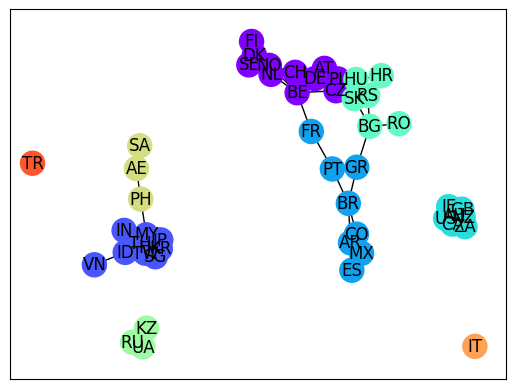

In [ ]:
communities = nx.algorithms.community.greedy_modularity_communities(G_image)
palette = plt.cm.rainbow

# draw communities in different colors
color_map = {}
for i, community in enumerate(communities):
    for node in community:
        color_map[node] = palette(i/len(communities))

colors = [color_map[node] for node in G_image.nodes()]

nx.draw_networkx(G_image, node_color=colors, with_labels=True)

## Structural metrics

In [194]:
def eval_properties(graph):
    # Reciprocity
    print("Reciprocity: ", nx.reciprocity(graph))

    # Density
    print("Density: ", nx.density(graph))

    # Average degree
    print("Average degree: ", np.mean(list(dict(graph.degree()).values())))

    # Degree assortativity
    print("Degree assortativity: ", nx.degree_assortativity_coefficient(graph))

    # Transitivity
    print("Transitivity: ", nx.transitivity(graph))

    # Clustering coefficient
    print("Clustering coefficient: ", nx.average_clustering(graph))

    # Connected components
    cc = list(nx.connected_components(graph))

    if len(cc) > 1:
        # get the largest component
        cc_max = graph.subgraph(cc[0])
        print("Number of nodes in the largest component: ", cc_max.number_of_nodes())

        try:
            # Average shortest path
            print("Average shortest path in the largest component: ", nx.average_shortest_path_length(cc_max))
        except nx.NetworkXError:
            print("Average shortest path in the largest component: ", "Not strongly connected", "Trying on the indirected graph...")
            print("Average shortest path in the largest component: ", nx.average_shortest_path_length(cc_max.to_undirected()))

        try:
            # Diameter
            print("Diameter of the largest cc: ", nx.diameter(cc_max))
        except nx.NetworkXError:
            print("Diameter of the largest cc: ", "Not strongly connected", "Trying on the indirected graph...")
            print("Diameter of the largest cc: ", nx.diameter(cc_max.to_undirected()))
    else:
        try:
            # Average shortest path
            print("Average shortest path: ", nx.average_shortest_path_length(graph))
        except nx.NetworkXError:
            pass

        try:
             # Diameter
            print("Diameter: ", nx.diameter(graph))
        except nx.NetworkXError:
            pass

In [ ]:
# get common nodes
common_nodes = set(G_image.nodes()).intersection(set(G_word.nodes()))

In [ ]:
# subset the graphs to common nodes
G_image_common = G_image.subgraph(common_nodes)
G_word_common = G_word.subgraph(common_nodes)

In [ ]:
eval_properties(G_image)

Reciprocity:  0.0
Density:  0.08865248226950355
Average degree:  4.166666666666667
Degree assortativity:  0.3597551453824284
Transitivity:  0.6748166259168704
Clustering coefficient:  0.6005952380952381
Number of nodes in the largest component:  3
Average shortest path in the largest component:  1.0
Diameter of the largest cc:  1


In [ ]:
eval_properties(G_word)

Reciprocity:  0.0
Density:  0.12195121951219512
Average degree:  4.878048780487805
Degree assortativity:  0.17175522931012036
Transitivity:  0.16795366795366795
Clustering coefficient:  0.25605532678703413
Number of nodes in the largest component:  30
Average shortest path in the largest component:  2.496551724137931
Diameter of the largest cc:  5


In [ ]:
# nx.write_gexf(G_image_common, "../network_backbone_top_countries_image_common.gexf")

## Communities - NMI

In [ ]:
# community detection
communities_words = nx.algorithms.community.greedy_modularity_communities(G_word_common)
communities_image = nx.algorithms.community.greedy_modularity_communities(G_image_common)
# print number of communities
print(len(communities_words))
print(len(communities_image))

5
5


In [180]:
node_to_community_words = {node: index for index, nodes in enumerate(communities_words) for node in nodes}
node_to_community_image = {node: index for index, nodes in enumerate(communities_image) for node in nodes}

In [181]:
# Calculate Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(list(node_to_community_words.values()), list(node_to_community_image.values()))

# Print the NMI score
print("NMI:", nmi)

NMI: 0.8515963672645437


## Edge overlap

In [ ]:
# compute the edge overlap between G_image and G_word
overlap_edges = set(G_image.edges()).intersection(set(G_word.edges()))
# Print the number of overlapping edges
print("Number of overlapping edges:", len(overlap_edges)/ len(G_image.edges()))

Number of overlapping edges: 0.14


## Jaccard community overlap

In [183]:
def jaccard_index(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 1.0

def average_best_match_jaccard(comms1, comms2):
    def best_match_avg(source, target):
        return sum(max(jaccard_index(s, t) for t in target) for s in source) / len(source) if source else 0.0
    
    score_1_to_2 = best_match_avg(comms1, comms2)
    score_2_to_1 = best_match_avg(comms2, comms1)
    
    return (score_1_to_2 + score_2_to_1) / 2, (score_1_to_2, score_2_to_1)

In [ ]:
# community detection
communities_words = nx.algorithms.community.greedy_modularity_communities(G_word)
communities_image = nx.algorithms.community.greedy_modularity_communities(G_image)
# print number of communities
print(len(communities_words))
print(len(communities_image))

5
7


In [185]:
similarity, (score1, score2) = average_best_match_jaccard(communities_words, communities_image)
print(f"Community-level Jaccard similarity: {similarity:.3f}")
print(f"Score 1 to 2: {score1:.3f}, Score 2 to 1: {score2:.3f}")

Community-level Jaccard similarity: 0.454
Score 1 to 2: 0.484, Score 2 to 1: 0.425
